## Clatification of Time Series Using 3 Order Cumlant and Convolutional Neural Network
### Converting time-series to images by using recurrence plot 


In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import sklearn
import sklearn.metrics.pairwise

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

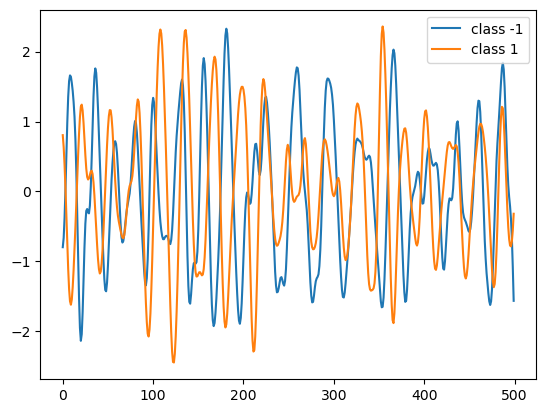

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [ ]:
# bispectrum用のパッケージstingrayのインストール
from stingray import Bispectrum
from stingray import lightcurve

def RP_generate(s, eps=None, steps=None):
    if eps==None: eps=0.1   # 閾値
    if steps==None: steps=10   # 閾値を何段階設定するか
    d = sklearn.metrics.pairwise.pairwise_distances(s)   # 距離行列
    d = np.floor(d / eps)   # Unthresholded Recurrence Plot
    d[d > steps] = steps
    d_steps = steps * np.ones(d.shape)
    d_re = d_steps - d   # 閾値内に入った時に点をプロットするような仕様に変更
    return d_re

c:\Users\u-kei\anaconda3\envs\keras-gpu\lib\site-packages\stingray\utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")


In [ ]:
maxlag = 50
X_train = np.zeros([x_train.shape[0], maxlag*2+1, maxlag*2+1])

for ii in range(x_train.shape[0]):
  ts = x_train[ii,:]
  times = np.arange(0,ts.shape[0])
  lc = lightcurve.Lightcurve(times,ts)
  bs = Bispectrum(lc, maxlag=maxlag, scale='unbiased')
  X_train[ii, :, :] = np.array(bs.cum3, dtype=np.float32)   # 3次自己相関関数
  # X_train[ii, :, :] = np.array(bs.bispec_mag, dtype=np.float32)   # バイスペクトル
  if ii % int(x_train.shape[0]/10) == 0:
    print('Status : %d ％' % int((ii+1)/x_train.shape[0]*100))

c:\Users\u-kei\anaconda3\envs\keras-gpu\lib\site-packages\stingray\lightcurve.py:310: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


Status : 0 ％
Status : 10 ％
Status : 20 ％
Status : 30 ％
Status : 40 ％
Status : 50 ％
Status : 60 ％
Status : 70 ％
Status : 80 ％
Status : 90 ％
Status : 100 ％


In [ ]:
X_test = np.zeros([x_test.shape[0], maxlag*2+1, maxlag*2+1])

for ii in range(x_test.shape[0]):
  ts = x_test[ii,:]
  times = np.arange(0,ts.shape[0])
  lc = lightcurve.Lightcurve(times,ts)
  bs = Bispectrum(lc, maxlag=maxlag, scale='unbiased')
  X_test[ii, :, :] = np.array(bs.cum3, dtype=np.float32)   # 3次自己相関関数
  # X_test[ii, :, :] = np.array(bs.bispec_mag, dtype=np.float32)   # バイスペクトル
  if ii % int(x_test.shape[0]/10) == 0:
    print('Status : %d ％' % int((ii+1)/x_test.shape[0]*100))

Status : 0 ％
Status : 10 ％
Status : 20 ％
Status : 30 ％
Status : 40 ％
Status : 50 ％
Status : 60 ％
Status : 70 ％
Status : 80 ％
Status : 90 ％


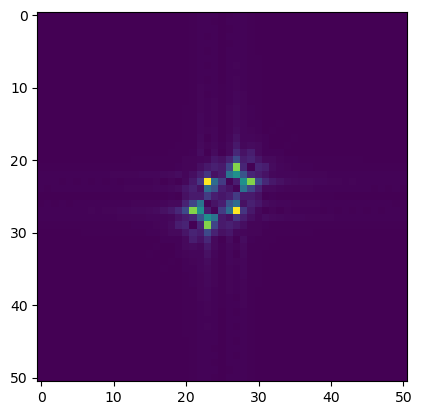

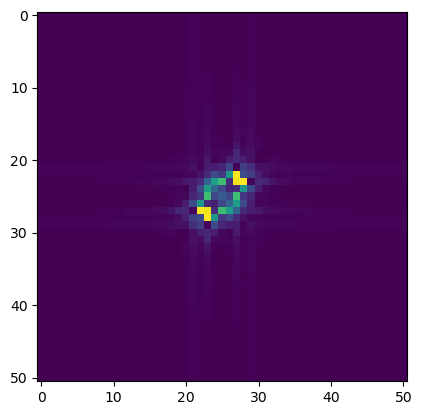

In [ ]:
for c in classes:
    plt.figure()
    c_X_train = X_train[y_train == c,:,:]
    plt.imshow(c_X_train[0], label="class " + str(c))
    plt.show()
    plt.close()

In [ ]:
# 正規化
X_train = np.array((X_train - X_train.min()) / X_train.max(), dtype=np.float32)

In [ ]:
# モデルがデータを読み込むには事前にunsqueeze的な作業が必要
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

In [ ]:
num_classes = len(np.unique(y_train))

In [ ]:
idx = np.random.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
batch_size = 32   # バッチサイズ
num_epochs = 500  # エポック数
filters1 = 64
filters2 = 64
kernel = 3
slide = 2
dropout1 = 0.25
dropout2 = 0.25
dropout3 = 0.5
dense = 128

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv2D(filters1, (kernel,kernel), activation='relu', data_format='channels_first')(input_layer)
    conv1 = keras.layers.MaxPooling2D(slide,slide)(conv1)
    conv1 = keras.layers.Dropout(dropout1)(conv1)

    conv2 = keras.layers.Conv2D(filters2, (kernel,kernel), activation='relu')(conv1)
    conv2 = keras.layers.MaxPooling2D(slide,slide)(conv2)
    conv2 = keras.layers.Dropout(dropout2)(conv2)
    conv2 = keras.layers.Flatten()(conv2)

    conv3 = keras.layers.Dense(dense, activation='relu')(conv2)
    conv3 = keras.layers.Dropout(dropout3)(conv3)

    output_layer = keras.layers.Dense(2, activation="softmax")(conv3)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 2s 11ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.5601 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.5617
Epoch 2/500
90/90 [==============================] - 1s 10ms/step - loss: 0.6102 - sparse_categorical_accuracy: 0.6396 - val_loss: 0.6134 - val_sparse_categorical_accuracy: 0.6380
Epoch 3/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5852 - sparse_categorical_accuracy: 0.6590 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.6338
Epoch 4/500
90/90 [==============================] - 1s 10ms/step - loss: 0.5698 - sparse_categorical_accuracy: 0.6642 - val_loss: 0.5882 - val_sparse_categorical_accuracy: 0.6436
Epoch 5/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5561 - sparse_categorical_accuracy: 0.6760 - val_loss: 0.5687 - val_sparse_categorical_accuracy: 0.6505
Epoch 6/500
90/90 [==============================] - 1s 9ms/step - loss: 0.5408 - sparse_categorical_

In [ ]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 4ms/step - loss: 253.2112 - sparse_categorical_accuracy: 0.5583
Test accuracy 0.5583333373069763
Test loss 253.2112274169922


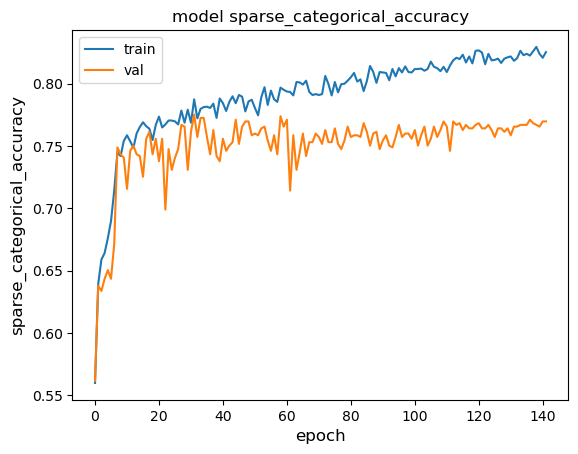

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

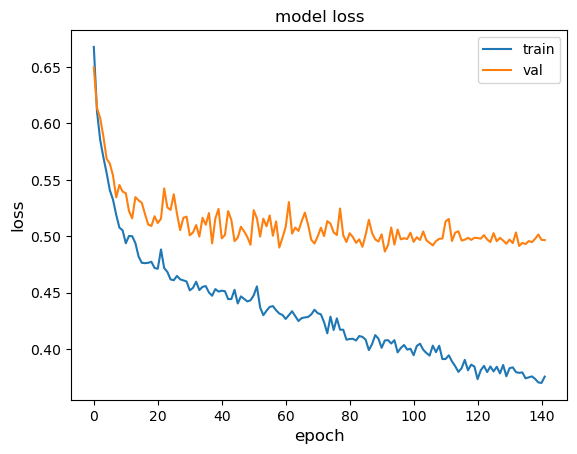

In [ ]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

### Reference
#### https://keras.io/examples/timeseries/timeseries_classification_from_scratch/
#### https://www.kaggle.com/code/tigurius/recuplots-and-cnns-for-time-series-classification/notebook